> **Data Analysis**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['y_train.csv', 'sample_submission.csv', 'X_test.csv', 'X_train.csv']


In [2]:
X_train = pd.read_csv("../input/X_train.csv")
y_train = pd.read_csv("../input/y_train.csv")
X_test = pd.read_csv("../input/X_test.csv")

X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [3]:
X_test.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439
1,0_1,0,1,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273
2,0_2,0,2,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990
3,0_3,0,3,-0.025566,-0.98862,-0.14817,0.003609,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270
4,0_4,0,4,-0.025548,-0.98866,-0.14792,0.003477,0.152050,-0.029016,-0.015314,3.39960,2.7881,-10.4100


In [4]:
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


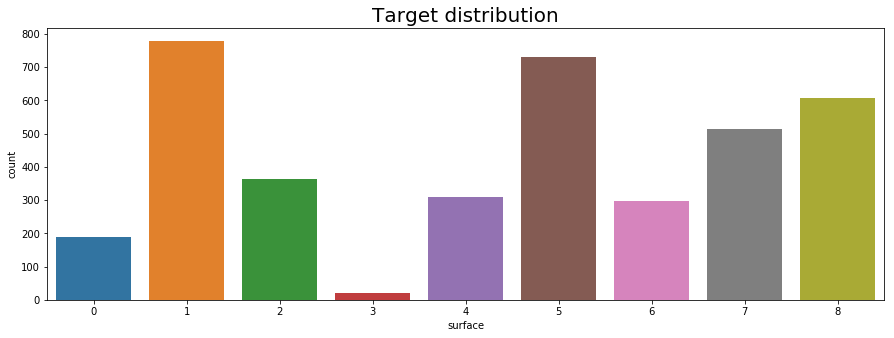

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
sns.countplot(y_train['surface'])
plt.title('Target distribution', size=20)
plt.show()

> **Data Preprocessing**

In [5]:
missing_data = X_train.isnull().sum()
print ("Missing Data in Training set")
missing_data.tail()

Missing Data in Training set


angular_velocity_Y       0
angular_velocity_Z       0
linear_acceleration_X    0
linear_acceleration_Y    0
linear_acceleration_Z    0
dtype: int64

In [6]:
missing_data = X_train.isnull().sum()
print ("Missing Data in Test set")
missing_data.tail()

Missing Data in Test set


angular_velocity_Y       0
angular_velocity_Z       0
linear_acceleration_X    0
linear_acceleration_Y    0
linear_acceleration_Z    0
dtype: int64

In [7]:
def feature_engineering(data):
    
    df = pd.DataFrame()
    data['totl_anglr_vel'] = (data['angular_velocity_X']**2 + data['angular_velocity_Y']**2 +
                             data['angular_velocity_Z']**2)** 0.5
    data['totl_linr_acc'] = (data['linear_acceleration_X']**2 + data['linear_acceleration_Y']**2 +
                             data['linear_acceleration_Z'])**0.5
    data['totl_xyz'] = (data['orientation_X']**2 + data['orientation_Y']**2 +
                             data['orientation_Z'])**0.5
   
    data['acc_vs_vel'] = data['totl_linr_acc'] / data['totl_anglr_vel']
    
    for col in data.columns:
        if col in ['row_id','series_id','measurement_number']:
            continue
        df[col + '_mean'] = data.groupby(['series_id'])[col].mean()
        df[col + '_median'] = data.groupby(['series_id'])[col].median()
        df[col + '_max'] = data.groupby(['series_id'])[col].max()
        df[col + '_min'] = data.groupby(['series_id'])[col].min()
        df[col + '_std'] = data.groupby(['series_id'])[col].std()
        df[col + '_range'] = df[col + '_max'] - df[col + '_min']
        df[col + '_maxtoMin'] = df[col + '_max'] / df[col + '_min']
        df[col + '_mean_abs_chg'] = data.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        df[col + '_abs_max'] = data.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        df[col + '_abs_min'] = data.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        df[col + '_abs_avg'] = (df[col + '_abs_min'] + df[col + '_abs_max'])/2
    return df

In [8]:
%%time
X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)
print(X_train.shape)


(3810, 154)
CPU times: user 1min 4s, sys: 228 ms, total: 1min 4s
Wall time: 1min 3s


> **Labels Encoding**

In [9]:
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

y_train['surface']= le.fit_transform(y_train['surface'])
y_train.head()

,series_id,group_id,surface
0,0,13,2
1,1,31,1
2,2,20,1
3,3,31,1
4,4,22,6


> **Handling Missing Values**

In [11]:
X_train.fillna(0, inplace = True)
X_test.fillna(0, inplace = True)
X_train.replace(-np.inf,0,inplace=True)
X_train.replace(np.inf,0,inplace=True)
X_test.replace(-np.inf,0,inplace=True)
X_test.replace(np.inf,0,inplace=True)

> **Model Building**

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold

def k_folds(X, y, X_test, k):
    folds = StratifiedKFold(n_splits = k, shuffle=True, random_state=20)
    y_test = np.zeros((X_test.shape[0], 9))
    y_oof = np.zeros((X.shape[0]))
    score = 0
    for i, (train_idx, val_idx) in  enumerate(folds.split(X, y)):
        clf =  RandomForestClassifier(n_estimators = 100, n_jobs = -1)
        clf.fit(X_train.iloc[train_idx], y[train_idx])
        y_oof[val_idx] = clf.predict(X.iloc[val_idx])
        y_test += clf.predict_proba(X_test) / folds.n_splits
        score += clf.score(X.iloc[val_idx], y[val_idx])
#         print('Fold: {} score: {}'.format(i,clf.score(X.iloc[val_idx], y[val_idx])))
    print('Avg Accuracy', score / folds.n_splits) 
        
    return y_oof, y_test 

In [17]:
y_oof, y_test = k_folds(X_train, y_train['surface'], X_test, k= 10)

Avg Accuracy 0.8847811570885445


In [14]:
confusion_matrix(y_oof,y_train['surface'])

array([[153,   5,   0,   0,   3,   1,   2,   4,   0],
       [ 15, 695,  21,   1,  14,  17,   4,  25,  16],
       [  0,  10, 294,   0,   4,   5,   0,   5,   7],
       [  0,   0,   0,  11,   0,   0,   0,   0,   0],
       [  1,  11,   1,   0, 279,   5,   0,   2,   1],
       [  5,  19,  12,   0,   1, 678,   7,   8,  27],
       [  4,   8,   2,   2,   1,   8, 279,   6,   3],
       [  1,  11,   8,   0,   0,   2,   0, 454,  19],
       [ 10,  20,  25,   7,   6,  16,   5,  10, 534]])

> **Predictions Submission**

In [15]:
y_test = np.argmax(y_test, axis=1)
submission = pd.read_csv(os.path.join("../input/",'sample_submission.csv'))
submission['surface'] = le.inverse_transform(y_test)
submission.to_csv('submission.csv', index=False)
submission.head(10)

,series_id,surface
0,0,hard_tiles_large_space
1,1,carpet
2,2,tiled
3,3,carpet
4,4,soft_tiles
5,5,concrete
6,6,concrete
7,7,concrete
8,8,wood
9,9,wood
